In [0]:
import torch
from torch.utils.data.dataloader import DataLoader
import minGPT
from minGPT.mingpt.utils import set_seed

set_seed(3407)
print(torch.cuda.device_count())
from torch.nn import functional as F
import numpy as np
import InContextLearningExperiments.icldatasets_new_idea as datasets

1


In [0]:
import importlib
importlib.reload(datasets)
importlib.reload(minGPT)

<module 'minGPT' (namespace) from ['/Workspace/Users/naman.agarwal@dreamsports.group/minGPT', '/Workspace/Users/naman.agarwal@dreamsports.group/minGPT']>

In [0]:
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [0]:
# Set context length (2*length+1) and vocab_size
train_dataset_mixed_dict = {}
mixed_loaders = {}
l = 100
length = l
vocab_size = l
p=0.1
# train_dataset_changing_dict[l] = datasets.KVRetrievalDatasetChangingDictNewIdea('train', vocab_size=vocab_size, length=length, perm_or_random='perm')
# changing_loader[l] = DataLoader(train_dataset_changing_dict, batch_size=1, num_workers=0, drop_last=False)
train_dataset_mixed_dict[l] = datasets.KVRetrievalDatasetMixedDictNewIdea('train', vocab_size=vocab_size, length=length, mixing_fraction=1-p, perm_or_random='perm')
mixed_loaders[l] = DataLoader(train_dataset_mixed_dict[l], batch_size=1, num_workers=0, drop_last=False)

ideal = (np.log(float(math.factorial(l))) + p*(np.log(float(math.factorial(l))))) / (2*l)
dumb_mode = (np.log(float(math.factorial(l))) + p*l*(np.log(float(l)))) / (2*l)
print(f'Ideal entropy {ideal:0.5f}, Dumb Entropy {dumb_mode:0.5f}')

Ideal entropy 2.00057, Dumb Entropy 2.04896


In [0]:
import importlib
import minGPT.mingpt.model
import minGPT.mingpt.trainer
importlib.reload(minGPT.mingpt.model)
importlib.reload(minGPT.mingpt.trainer)
# create a GPT instance
from minGPT.mingpt.model import GPT
# create a Trainer object
from minGPT.mingpt.trainer import Trainer

import numpy as np

losses = []
def batch_end_callback(trainer):
    losses.append(trainer.loss.item())
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}; mean loss last 20 iters: {np.mean(losses[-20:]):.5f}")
        print(f"Current LR {trainer.optimizer.param_groups[0]['lr']:.7f}")

In [0]:
depths = [20]
n_embd = 192
heads = [6]
model_dicts = {}
trainer_dicts = {}
for d in depths:
  for h in heads:
    length = l
    vocab_size = l
    model_config = GPT.get_default_config()
    print(model_config)
    model_config.model_type = None
    model_config.vocab_size = 2*vocab_size
    model_config.block_size = 2*length - 1
    model_config.n_layer = d
    model_config.n_head = h
    model_config.n_embd = n_embd
    model_config.embd_pdrop = 0.
    model_config.resid_pdrop = 0.
    model_config.attn_pdrop = 0.
    

    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
    train_config.max_iters = 50000
    train_config.num_workers = 0
    train_config.lr_schedule = None
    model_dicts[(d, h)] = GPT(model_config)
    trainer_dicts[(d, h)] = Trainer(train_config, model_dicts[(d, h)], train_dataset_mixed_dict[l])
    trainer_dicts[(d, h)].set_callback('on_batch_end', batch_end_callback)
    trainer_dicts[(d, h)].run()


model_type: gpt
n_layer: None
n_head: None
n_embd: None
vocab_size: None
block_size: None
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 8.97M


---------------------------------------------------------------------------
OutOfMemoryError                          Traceback (most recent call last)
File <command-3454245798761289>, line 29
     27 train_config.lr_schedule = None
     28 model_dicts[(d, h)] = GPT(model_config)
---> 29 trainer_dicts[(d, h)] = Trainer(train_config, model_dicts[(d, h)], train_dataset_mixed_dict[l])
     30 trainer_dicts[(d, h)].set_callback('on_batch_end', batch_end_callback)
     31 trainer_dicts[(d, h)].run()

File /Workspace/Users/naman.agarwal@dreamsports.group/minGPT/mingpt/trainer.py:47, in Trainer.__init__(self, config, model, train_dataset)
     45 else:
     46     self.device = config.device
---> 47 self.model = self.model.to(self.device)
     48 print("running on device", self.device)
     50 # variables that will be assigned to trainer class later for logging and etc

File /databricks/python/lib/python3.12/site-packages/torch/nn/modules/module.py:1343, in Module.to(self, *args, **kwargs)
  

In [0]:
import time
import torch  # or use any minimal computation

def keep_alive(interval_minutes=4):
    print("Keeping the cluster alive...")
    while True:
        # Minimal computation (e.g., a small tensor operation)
        _ = torch.tensor([1.0]) * 1.000001

        print("Pinged at", time.ctime())
        time.sleep(interval_minutes * 60)  # Sleep for N minutes

# Call the function
keep_alive()

Keeping the cluster alive...
Pinged at Fri Aug  1 14:47:35 2025


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
import math
from scipy.stats import entropy
import numpy as np

In [0]:
import itertools

[0.7777970418770244, 0.01363251088635183, 0.00018888000906163983, 2.446850132776881e-06, 3.056756478755483e-08, 3.7392415786030607e-10, 4.517043736626265e-12, 5.286484197511814e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


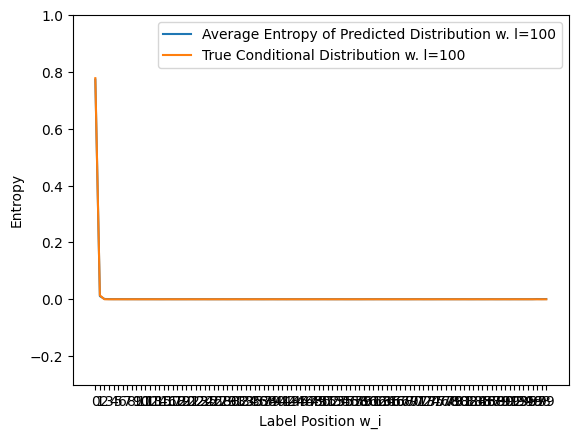

[0.7777970418770244, 0.01363251088635183, 0.00018888000906163983, 2.446850132776881e-06, 3.056756478755483e-08, 3.7392415786030607e-10, 4.517043736626265e-12, 5.286484197511814e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


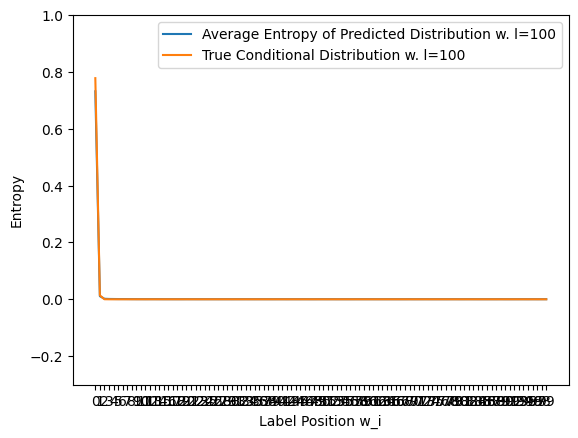

[0.7777970418770244, 0.01363251088635183, 0.00018888000906163983, 2.446850132776881e-06, 3.056756478755483e-08, 3.7392415786030607e-10, 4.517043736626265e-12, 5.286484197511814e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


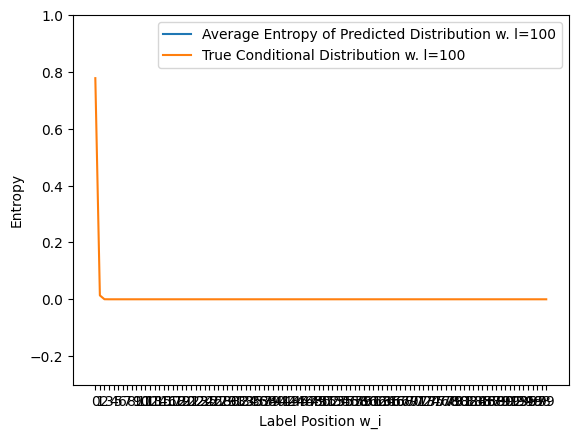

In [0]:
for (k,(d, n_embd)) in enumerate(list(itertools.product(depths, heads))):
  model_dict = model_dicts[(d, n_embd)]
  trainer_dict = trainer_dicts[(d, n_embd)]
  loader = mixed_loaders[l]
  train_dataset_fixed_dict = datasets.KVRetrievalDatasetFixedDictNewIdea('train', vocab_size=l, length=l, mixing_fraction=1.0, perm_or_random='perm', dictionary=loader.dataset.dictionary)
  fixed_loader = DataLoader(train_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)

  samples = []
  for j in range(100):
    a,b = next(iter(fixed_loader))
    samples.append([a,b])

  all_ents = []
  for a,b in samples:
    ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
    probs = F.softmax(ans[1], dim=-1)
    dict_so_far = {}
    things_fixed = 0
    entropies = []
    for i in range(0, ans[1].size(1), 2):
      entropies.append(entropy(probs[0][i].cpu().numpy()))
    all_ents.append(entropies)
  all_ents = np.array(all_ents)
  #print(all_ents)

  true_entropies = []
  for i in range(0, ans[1].size(1), 2):
    q = a[0][i].cpu().item()
    qa = b[0][i].cpu().item()
    j = i // 2
    pa = (0.9 + 0.1*math.factorial(l - (j+1))/math.factorial(l)) / (0.9 + 0.1*math.factorial(l - (j))/math.factorial(l))
    pb = (1 - pa)/(l-1) 
    #print(pa)
    true_entropies.append(entropy([pa] + [pb]*(l-1)))
    # if q in dict_so_far:
    #   true_entropies.append(np.log(1))
    # else:
    #   true_entropies.append(np.log(vocab_size - things_fixed))
    #   dict_so_far[q] = qa
    #   things_fixed += 1
    
  print(true_entropies)
  stds = np.std(all_ents, axis=0)
  #print(stds)
  all_ents = np.mean(all_ents, axis=0)
  # if k == 0:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')
  # else:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1)

  plt.plot(all_ents, label=f'Average Entropy of Predicted Distribution w. l={l}')

  plt.plot(true_entropies, label=f'True Conditional Distribution w. l={l}')
  plt.xlabel('Label Position w_i')
  plt.ylim(-0.3, 1.0)
  plt.xticks(range(len(all_ents)))
  plt.ylabel('Entropy')
  plt.legend()
  plt.show()

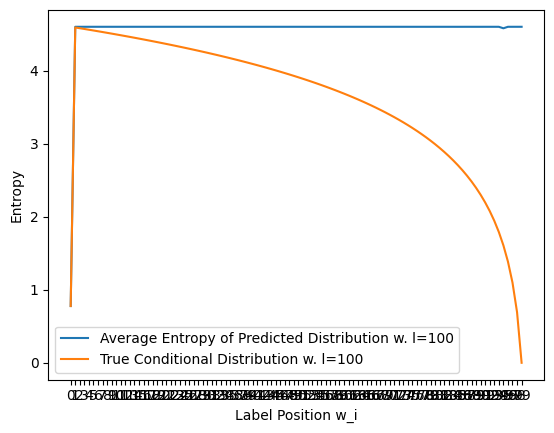

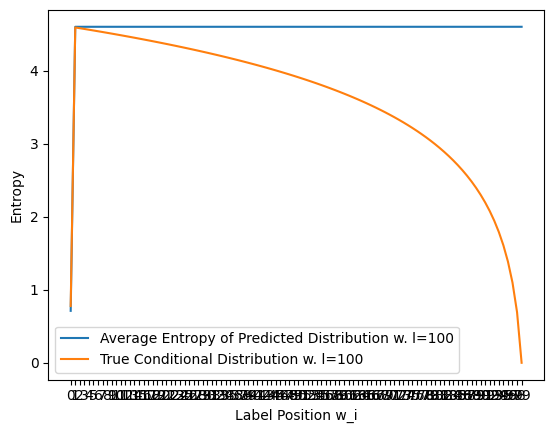

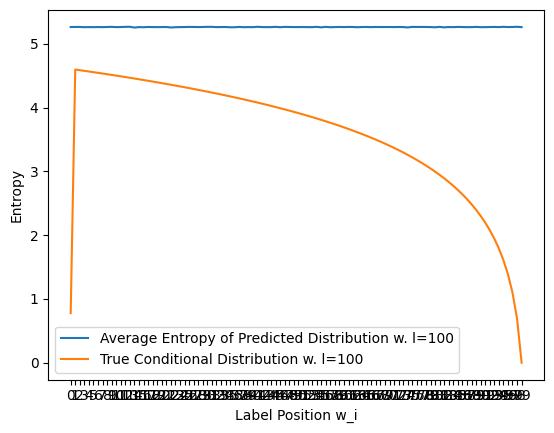

In [0]:
for (k,(d, n_embd)) in enumerate(list(itertools.product(depths, heads))):
  model_dict = model_dicts[(d, n_embd)]
  trainer_dict = trainer_dicts[(d, n_embd)]
  loader = mixed_loaders[l]
  #print(loader.dataset.dictionary)
  train_dataset_changing_dict = datasets.KVRetrievalDatasetChangingDictNewIdea('train', vocab_size=l, length=l, perm_or_random='perm')
  changing_loader = DataLoader(train_dataset_changing_dict, batch_size=1, num_workers=0, drop_last=False)

  samples = []
  j = 0
  while j < 100:
    a,b = next(iter(changing_loader))
    #print(a,b)
    if loader.dataset.dictionary[a[0][0]] != b[0][0]:
      j+=1
      samples.append([a,b])

  all_ents = []
  for a,b in samples:
    ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
    probs = F.softmax(ans[1], dim=-1)
    dict_so_far = {}
    things_fixed = 0
    entropies = []
    for i in range(0, ans[1].size(1), 2):
      entropies.append(entropy(probs[0][i].cpu().numpy()))
    all_ents.append(entropies)
  all_ents = np.array(all_ents)
  #print(all_ents)

  true_entropies = []
  for i in range(0, ans[1].size(1), 2):
    if i==0:
      q = a[0][i].cpu().item()
      qa = b[0][i].cpu().item()
      j = i // 2
      pa = (0.9 + 0.1*math.factorial(l - (j+1))/math.factorial(l)) / (0.9 + 0.1*math.factorial(l - (j))/math.factorial(l))
      pb = (1 - pa)/(l-1)
      #print(pa)
      true_entropies.append(entropy([pa] + [pb]*(l-1)))
    else:
      true_entropies.append(np.log(l - i//2))
    
  #print(entropies)
  stds = np.std(all_ents, axis=0)
  #print(stds)
  all_ents = np.mean(all_ents, axis=0)
  # if k == 0:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')
  # else:
  #   plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1)

  plt.plot(all_ents, label=f'Average Entropy of Predicted Distribution w. l={l}')

  plt.plot(true_entropies, label=f'True Conditional Distribution w. l={l}')
  plt.xlabel('Label Position w_i')
  plt.xticks(range(len(all_ents)))
  plt.ylabel('Entropy')
  plt.legend()
  plt.show()

In [0]:
#train_dataset_fixed_dict = datasets.KVRetrievalDatasetFixedDictNewIdea('train', vocab_size=vocab_size, length=length, mixing_fraction=0.9, perm_or_random='perm', dictionary=loader.dataset.dictionary)
#fixed_loader = DataLoader(train_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)

samples = []
j = 0
while j < 100:
  a,b = next(iter(loader))
  if loader.dataset.dictionary[a[0][0]] != b[0][0]:
    j+=1
    samples.append([a,b])
  

all_ents = []
for a,b in samples:
  ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
  probs = F.softmax(ans[1], dim=-1)
  dict_so_far = {}
  things_fixed = 0
  entropies = []
  for i in range(0, ans[1].size(1), 2):
    entropies.append(entropy(probs[0][i].cpu().numpy()))
  all_ents.append(entropies)
all_ents = np.array(all_ents)
#print(all_ents)

true_entropies = []
for i in range(0, ans[1].size(1), 2):
  if i==0:
    q = a[0][i].cpu().item()
    qa = b[0][i].cpu().item()
    j = i // 2
    pa = (0.9 + 0.1*math.factorial(10 - (j+1))/math.factorial(10)) / (0.9 + 0.1*math.factorial(10 - (j))/math.factorial(10))
    pb = (1 - pa)/9 
    #print(pa)
    true_entropies.append(entropy([pa] + [pb]*9))
  else:
    true_entropies.append(np.log(10 - i//2))
  # if q in dict_so_far:
  #   true_entropies.append(np.log(1))
  # else:
  #   true_entropies.append(np.log(vocab_size - things_fixed))
  #   dict_so_far[q] = qa
  #   things_fixed += 1
  
#print(entropies)
stds = np.std(all_ents, axis=0)
print(stds)
all_ents = np.mean(all_ents, axis=0)
plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')

plt.plot(all_ents, label='Average Entropy of Predicted Distribution')
plt.plot(true_entropies, label='True Conditional Distribution')
plt.xlabel('Label Position w_i')
plt.xticks(range(len(all_ents)))
plt.ylabel('Entropy')
plt.legend()
plt.show()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
samples = []
j = 0
while j < 100:
  a,b = next(iter(loader))
  if (loader.dataset.dictionary[a[0][0]] == b[0][0]) and (loader.dataset.dictionary[a[0][2]] != b[0][2]):
    j+=1
    samples.append([a,b])
  

all_ents = []
for a,b in samples:
  ans=model_dict.generate(a.to(trainer_dict.device), 1, do_sample=False)
  probs = F.softmax(ans[1], dim=-1)
  dict_so_far = {}
  things_fixed = 0
  entropies = []
  for i in range(0, ans[1].size(1), 2):
    entropies.append(entropy(probs[0][i].cpu().numpy()))
  all_ents.append(entropies)
all_ents = np.array(all_ents)
#print(all_ents)

true_entropies = []
for i in range(0, ans[1].size(1), 2):
  if i < 3:
    q = a[0][i].cpu().item()
    qa = b[0][i].cpu().item()
    j = i // 2
    pa = (0.9 + 0.1*math.factorial(10 - (j+1))/math.factorial(10)) / (0.9 + 0.1*math.factorial(10 - (j))/math.factorial(10))
    pb = (1 - pa)/9 
    #print(pa)
    true_entropies.append(entropy([pa] + [pb]*9))
  else:
    true_entropies.append(np.log(10 - i//2))
  # if q in dict_so_far:
  #   true_entropies.append(np.log(1))
  # else:
  #   true_entropies.append(np.log(vocab_size - things_fixed))
  #   dict_so_far[q] = qa
  #   things_fixed += 1
  
#print(entropies)
stds = np.std(all_ents, axis=0)
print(stds)
all_ents = np.mean(all_ents, axis=0)
plt.fill_between(range(len(all_ents)), all_ents - stds, all_ents + stds, color='blue', alpha=0.1, label='±1 Std Dev Entropy of Predicted Distribution')

plt.plot(all_ents, label='Average Entropy of Predicted Distribution')
plt.plot(true_entropies, label='True Conditional Distribution')
plt.xlabel('Label Position w_i')
plt.xticks(range(len(all_ents)))
plt.ylabel('Entropy')
plt.legend(loc='upper right')
plt.show()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:

# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_fixed_dict = eval_split(trainer_fixed_dict, model_fixed_dict, train_dataset_fixed_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_fixed_dict, model_fixed_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
loader = DataLoader(test_dataset_fixed_dict, batch_size=1, num_workers=0, drop_last=False)
a = next(iter(loader))
a = [a[0].to(trainer_fixed_dict.device), a[1].to(trainer_fixed_dict.device)]

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:

print(a)
with torch.no_grad():
  cat, att_matrices = model_fixed_dict.generate(a[0], 1, do_sample=False)
  print(cat)
  print(att_matrices)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import pandas as pd

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
print(type(att_matrices[0][0]))
print(att_matrices[0][0].size())
for i in range(att_matrices[0][0].size()[1]):
  #plt.imshow(att_matrices[0][0][0][i].cpu(), cmap='hot', interpolation='nearest')
  ax = sns.heatmap(att_matrices[0][0][0][i].cpu(), linewidth=0.5, norm=LogNorm())
  plt.show()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
def prettyprint(A):
  A = np.array(A)
  A = pd.DataFrame(A)
  A.columns = ['']*A.shape[1]
  print(A.to_string(index=False))

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
prettyprint(att_matrices[0][0][0][0].cpu())

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
model_changing_dict = GPT(model_config)
train_config.max_iters = 10000
trainer_changing_dict = Trainer(train_config, model_changing_dict, train_dataset_changing_dict)
trainer_changing_dict.set_callback('on_batch_end', batch_end_callback)
trainer_changing_dict.run()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# running a non cl trained trainer through non_cl dataset
with torch.no_grad():
    train_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, train_dataset_changing_dict, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_changing_dict, model_changing_dict, test_dataset_mixed_dict_x1, max_batches=50, split='test')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
model_mixed_dict_x1 = GPT(model_config)
train_config.max_iters = 10000
trainer_mixed_dict_x1 = Trainer(train_config, model_mixed_dict_x1, train_dataset_mixed_dict_x1)
trainer_mixed_dict_x1.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1.run()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
for b, (x, y) in enumerate(loader):
    #print(x,y)
    x = x.to(trainer.device)
    y = y.to(trainer.device)
    # isolate the input pattern alone
    inp = x
    sol = y[:, -1]
    #print(inp.size())
    # let the model sample the rest of the sequence
    cat, att_matrices = model.generate(inp, 1, do_sample=False) # using greedy argmax, not sampling
    print(len(att_matrices))
    sol_candidate = cat[:, -1] # isolate the filled in sequence
    # compare the predicted sequence to the true sequence
    #print(sol, sol_candidate)
    correct = (sol == sol_candidate).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
    #print(x.size(0))
    #print(correct)
    for i in range(x.size(0)):
        results.append(int(correct[i]))
        if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
            mistakes_printed_already += 1
            print("GPT claims that %s sorted is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
    if max_batches is not None and b+1 >= max_batches:
        break

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
print(train_dataset_mixed_dict_x1.dictionary)
print(train_dataset_fixed_dict.dictionary)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, train_dataset_mixed_dict_x1, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1, model_mixed_dict_x1, test_dataset_mixed_dict_x1, max_batches=50, split='test')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
from torch.utils.data import Dataset

class KVRetrievalDatasetMixedDictSeparatedVocab(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = 2*vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def _generate_extended_dictionary(self):
        return torch.randperm(self.true_vocab_size) + self.true_vocab_size

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        decider = torch.rand(1) < 0.5
        dictionary = self.dictionary if decider else self._generate_extended_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0) if decider else torch.concat([context_keys + self.true_vocab_size, question_key + self.true_vocab_size], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)


        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
train_dataset_mixed_dict_x1_sep_vocab = KVRetrievalDatasetMixedDictSeparatedVocab('train', length=length, dictionary=train_dataset_fixed_dict.dictionary, mixing_fraction=0.5, vocab_size=vocab_size)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
print(train_dataset_mixed_dict_x1_sep_vocab.dictionary)
print(train_dataset_fixed_dict.dictionary)

for i in range(15):
  print(train_dataset_mixed_dict_x1_sep_vocab[i])

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = 2*vocab_size+2
model_config.block_size = 2*length + 1

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 50000
train_config.num_workers = 0

model_mixed_dict_x1_sep_vocab = GPT(model_config)
trainer_mixed_dict_x1_sep_vocab = Trainer(train_config, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab)
trainer_mixed_dict_x1_sep_vocab.set_callback('on_batch_end', batch_end_callback)
trainer_mixed_dict_x1_sep_vocab.run()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
with torch.no_grad():
    train_score_mixed_dict_x1_sep_vocab = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, train_dataset_mixed_dict_x1_sep_vocab, max_batches=50, split='train')
    test_score_fixed_dict  = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_fixed_dict, max_batches=50, split='test')
    test_score_changing_dict = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_changing_dict, max_batches=50, split='test')
    test_score_mixed_dict_x1 = eval_split(trainer_mixed_dict_x1_sep_vocab, model_mixed_dict_x1_sep_vocab, test_dataset_mixed_dict_x1, max_batches=50, split='test')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# running a non cl trained trainer through non_cl dataset
# shows roughly random accuracy
with torch.no_grad():
    train_score = eval_split(trainer_non_cl, model_non_cl, train_dataset_cl, max_batches=50, split='train')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# what if we try introducing a new key does thats not in voacb
inp = torch.tensor([[11, 7]*length + [10]])
inp = inp.to(trainer_non_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_non_cl.generate(inp, 1, do_sample=False)
  print(cat)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl = GPT(model_config)
trainer_cl = Trainer(train_config, model_cl, train_dataset_cl)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl.set_callback('on_batch_end', batch_end_callback)

trainer_cl.run()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl, model_cl, train_dataset_cl, max_batches=50, split='train')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[6, 7]*length + [6]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[11, 7]*length + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 1, 2, 1, 2, 11, 7, 1, 2, 1, 2] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  cat = model_cl.generate(inp, 1, do_sample=False)
  print(cat)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# even when we try a long sequence of repeatedly the right prompts 
inp = torch.tensor([[1, 2, 11, 3, 1, 2, 11, 7, 1, 2, 11, 5] + [11]])
inp = inp.to(trainer_cl.device)
print(inp, inp.size())
with torch.no_grad():
  for i in range(30):
    cat = model_cl.generate(inp, 1, do_sample=False)
    print(cat[0, -1])

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# Generating mixed datasets

class KVRetrievalDatasetMixedDict(Dataset):
    """ 
    Dataset for InContext Learning. 
    """

    def __init__(self, split, length=6, vocab_size=10, additional_vocab = 2, dictionary=None, mixing_fraction=0.0):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.vocab_size = vocab_size + additional_vocab
        self.true_vocab_size = vocab_size
        self.mixing_fraction = mixing_fraction
        self.dictionary = dictionary if dictionary is not None else self._generate_dictionary()
          
    def _generate_dictionary(self):
        return torch.randperm(self.true_vocab_size)

    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 2*self.length + 1

    def __getitem__(self, idx):
        dictionary = self.dictionary if torch.rand(1) < self.mixing_fraction else self._generate_dictionary()
        context_keys = torch.randint(self.true_vocab_size, size=(self.length,), dtype=torch.long)
        context_labels = torch.index_select(dictionary, 0, context_keys)
        # find a key thats appeared in this context
        question_key = torch.index_select(context_keys, 0, torch.randint(self.length, size=(1,), dtype=torch.long))
        question_label = torch.index_select(dictionary, 0, question_key)
        # make final context
        context_keys = torch.concat([context_keys, question_key], dim=0)
        context_labels = torch.concat([context_labels, question_label], dim=0)
        
        #interleave them
        full_context = torch.flatten(torch.stack([context_keys, context_labels]).t())
        # provide everything but the last label to TX
        x = full_context[:-1].clone()
        # Mask everything but the last label in the loss
        y = full_context[1:].clone()
        y[:2*self.length] = -1
        return x, y


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
torch.rand(1)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:

train_dataset_cl_mixed = KVRetrievalDatasetMixedDict('train', length=length, mixing_fraction=0.9)

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset_cl.get_vocab_size()
model_config.block_size = train_dataset_cl.get_block_size()

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 10000
train_config.num_workers = 0

model_cl_mixed = GPT(model_config)
trainer_cl_mixed = Trainer(train_config, model_cl_mixed, train_dataset_cl_mixed)

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

trainer_cl_mixed.set_callback('on_batch_end', batch_end_callback)

trainer_cl_mixed.run()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
train_dataset_cl_mixed.dictionary

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
with torch.no_grad():
    train_score = eval_split(trainer_cl_mixed, model_cl_mixed, train_dataset_cl_mixed, max_batches=50, split='train')

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
# run the trainer with an accuracy module on test data to generate some plots

# next experiment should be using different vocabs for incontext and different vocabs for distributional. Can it still do in context for the vocab that it didnt learn in context for? 




com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
from scipy.stats import binom
import numpy as np

n = np.arange(5, 15, 1)
p = np.arange(0, 1, 0.05)
n = 1024

cdf_value = [binom.cdf(n//2, n, p_test) for p_test in p]

print(cdf_value)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
n

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
binom.cdf(4, 8, 0.1)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data